## Analyzing CIA Factbook Data Using SQLite & Python

In this project, we will be analyzing data from the CIA Factbook, which is a reference resource produced by the CIA with almanac-style information about countries around the world.

Let's start by connecting to the database and seeing what tables we can access.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

conn = sqlite3.connect('factbook.db')

In [2]:
query1 = '''SELECT * FROM sqlite_master WHERE type='table';'''
pd.read_sql_query(query1, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [3]:
query2 = '''SELECT * FROM facts LIMIT 5'''
pd.read_sql_query(query2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


## Summary Statistics

Now let's look at a few high-level summary statistics.

In [4]:
query3 = '''
            SELECT MIN(population) min_pop, MAX(population) max_pop, MIN(population_growth) min_pop_growth, MAX(population_growth) max_pop_growth
            FROM facts
         '''
pd.read_sql_query(query3, conn)

,min_pop,max_pop,min_pop_growth,max_pop_growth
0,0,7256490011,0.0,4.02


## Exploring Outliers

Both a minimum population of zero and a maximum population of ~7.3 billion seem odd.  Let's explore those outliers further.

In [5]:
query4 = '''
         SELECT *
         FROM facts
         WHERE population = 0
         '''
pd.read_sql_query(query4, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


In [6]:
query5 = '''
         SELECT *
         FROM facts
         WHERE population = (SELECT MAX(population) FROM facts)
         '''
pd.read_sql_query(query5, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


It looks like Antarctica and the entire world are included in the dataset, which justifies the outliers we noticed earlier.

## Data Exploration: Visualizing Key Statistics

Next, let's see what the distributions for different variables look like. 

C:\Users\nluth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029188C067F0>,
      dtype=object)

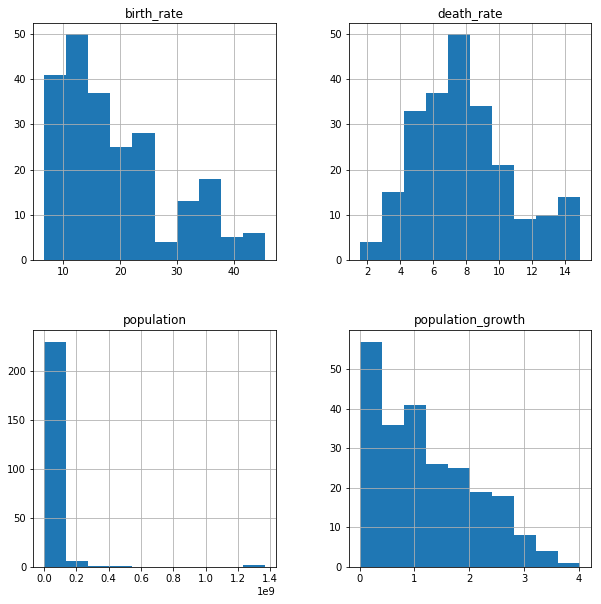

In [7]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)

query6 = '''
         SELECT population, population_growth, birth_rate, death_rate
         FROM facts
         WHERE (population != 0) AND (population != (SELECT MAX(population) FROM facts))
         '''

pd.read_sql_query(query6, conn).hist(ax=ax)

## Data Exploration: Population Density

Let's take a closer look at the population variable to see if we can derive a metric that will allow us to meaningfully compare populations across countries.

In [8]:
q7 = '''
     SELECT name country, CAST(population as Integer) / CAST(area as Integer) pop_density
     FROM facts
     ORDER BY pop_density DESC
     LIMIT 10
     '''
pd.read_sql_query(q7, conn)

,country,pop_density
0,Macau,21168
1,Monaco,15267
2,Singapore,8141
3,Hong Kong,6445
4,Gaza Strip,5191
5,Gibraltar,4876
6,Bahrain,1771
7,Maldives,1319
8,Malta,1310
9,Bermuda,1299


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002918A02A898>]],
      dtype=object)

<Figure size 720x720 with 0 Axes>

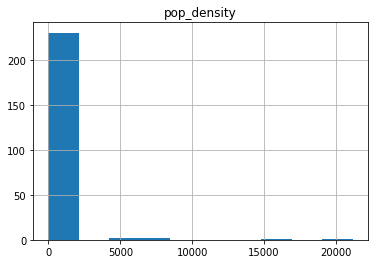

In [9]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot()

q8 = '''
     SELECT name country, CAST(population as Integer) / CAST(area as Integer) pop_density
     FROM facts
     '''
pd.read_sql_query(q8, conn).hist(ax=ax)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002918A40D748>]],
      dtype=object)

<Figure size 720x720 with 0 Axes>

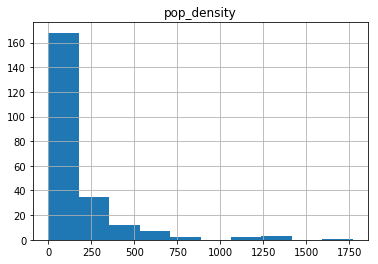

In [10]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot()

q9 = '''
     SELECT name country, CAST(population as Integer) / CAST(area as Integer) pop_density
     FROM facts
     WHERE pop_density < 4000
     '''
pd.read_sql_query(q9, conn).hist(ax=ax)